# Gaussianization Flows (Details)

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss

KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

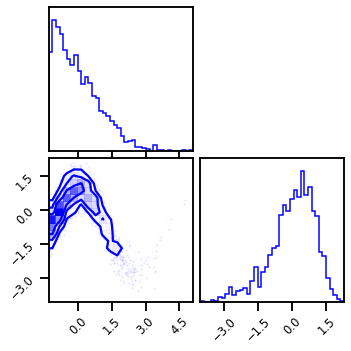

In [3]:
from sklearn.preprocessing import StandardScaler
# %%wandb
# get data
seed = 123
n_samples = 2_000
n_features = 2
data = get_classic(n_samples, seed=123)
data = StandardScaler().fit_transform(data)

# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

In [4]:
X = jnp.array(data, dtype=np.float32)

## Model

### Layer 1 - Mixture Gaussian CDF

In [5]:
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF

In [6]:
# spline parameters
range_min = -10.0
n_components = 10
n_features = 2
shape = (2,)
key = jax.random.PRNGKey(123)

In [7]:
init_mixcdf_f = InitMixtureLogisticCDF(
    n_components=n_components,
)

mcdf_bijector = init_mixcdf_f(key, n_features)

#### Forward Transformation

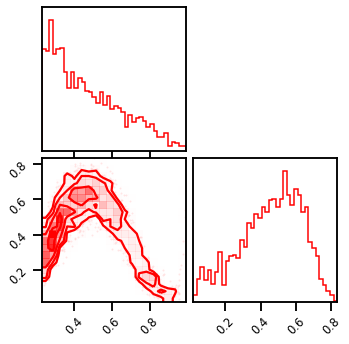

In [8]:
X_l1 = mcdf_bijector.forward(X)

# plot
fig = corner.corner(X_l1, color="red", hist_bin_factor=2)

#### Inverse Transformation

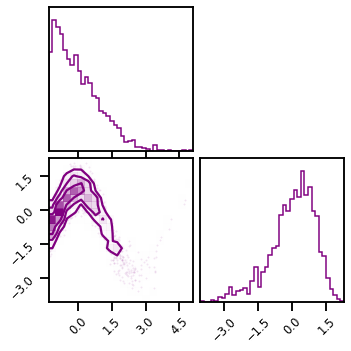

In [9]:
X_approx = mcdf_bijector.inverse(X_l1)

# plot
fig = corner.corner(X_approx, color="purple", hist_bin_factor=2)

#### Gradient Transformation

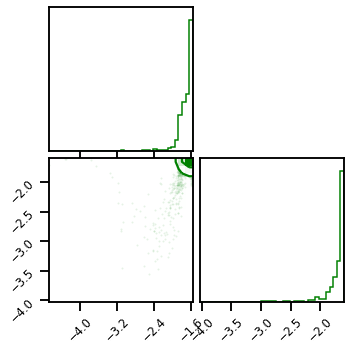

In [10]:
X_ldj = mcdf_bijector.forward_log_det_jacobian(X)

# plot
fig = corner.corner(X_ldj, color="green", hist_bin_factor=2)

### Layer II - Logit Transform

In [11]:
# Logit transform
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse

logit_bijector = Inverse(Sigmoid())

In [12]:
# from rbig_jax.transforms.logit import InitLogit

In [13]:
# # layer parameters
# init_func = InitLogit()


# # initialize the bijector
# key, hh_rng = jax.random.split(key, 2)
# bijectors.append(Inverse(Sigmoid()))

# logit_bijector = init_func(hh_rng, n_features)
logit_bijector = Inverse(Sigmoid())

#### Forward Transformation

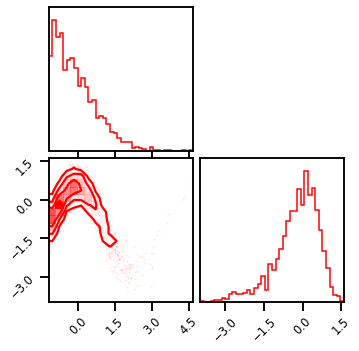

In [14]:
X_l2 = logit_bijector.forward(X_l1)

# plot
fig = corner.corner(X_l2, color="red", hist_bin_factor=2)

#### Inverse Transformation

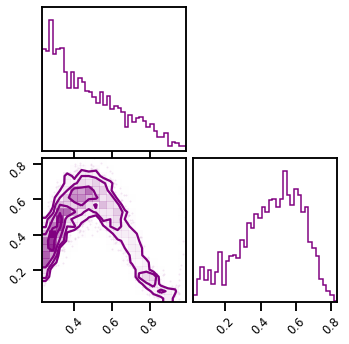

In [15]:
X_l1_approx = logit_bijector.inverse(X_l2)

# plot
fig = corner.corner(X_l1_approx, color="purple", hist_bin_factor=2)

#### Gradient Transformation

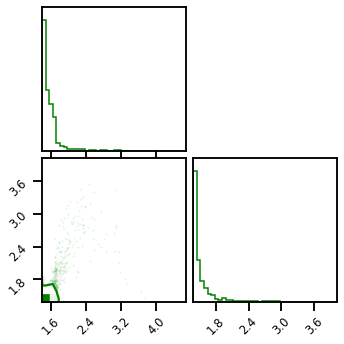

In [16]:
X_l2_ldj = logit_bijector.forward_log_det_jacobian(X_l1)


# plot
fig = corner.corner(X_l2_ldj, color="green", hist_bin_factor=2)

### Layer III - HouseHolder Reflections

In [17]:
from rbig_jax.transforms.parametric.householder import InitHouseHolder

# layer parameters
n_reflections = 2

init_func = InitHouseHolder(n_reflections=n_reflections)


# initialize the bijector
key, hh_rng = jax.random.split(key, 2)

hh_bijector = init_func(hh_rng, n_features)

#### Forward Transformation

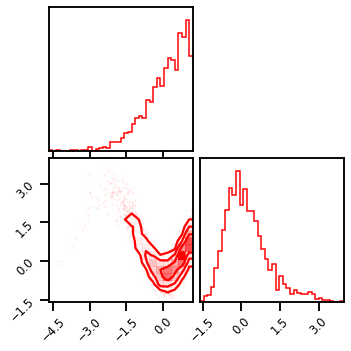

In [18]:
X_l3 = hh_bijector.forward(X_l2)

# plot
fig = corner.corner(X_l3, color="red", hist_bin_factor=2)

#### Inverse Transformation

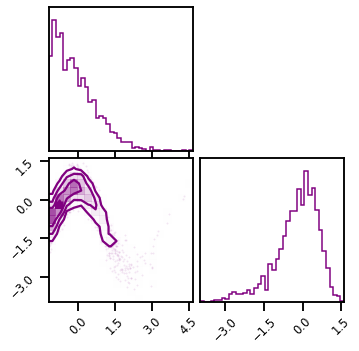

In [19]:
X_l2_approx = hh_bijector.inverse(X_l3)

# plot
fig = corner.corner(X_l2_approx, color="purple", hist_bin_factor=2)

#### Gradient Transformation

In [20]:
X_l3_ldj = hh_bijector.forward_log_det_jacobian(X_l2)

chex.assert_equal(X_l3_ldj.min(), X_l3_ldj.max())

## Chaining Transformations

In [21]:
from rbig_jax.transforms.base import cascade_forward_and_log_det, cascade_inverse_and_log_det

#### Forward Transformation

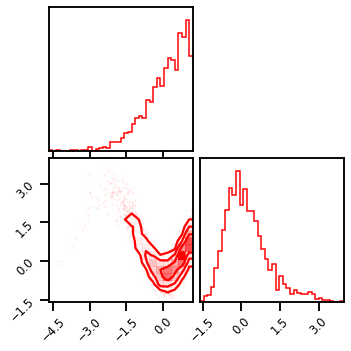

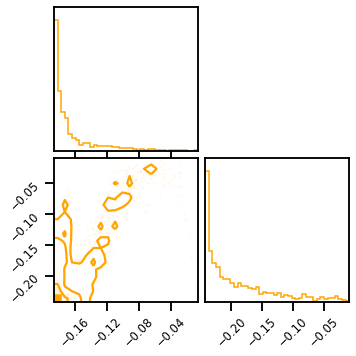

In [22]:
# initialize list of bijectors
bijectors = [
    mcdf_bijector,
    logit_bijector,
    hh_bijector
]

# cascade the transform
X_l2, X_l2_ldj = cascade_forward_and_log_det(bijectors, X)

# plot latent space
fig = corner.corner(X_l2, color="red", hist_bin_factor=2)

# plot gradient
fig = corner.corner(X_l2_ldj, color="orange", hist_bin_factor=2)

#### Inverse Transformation

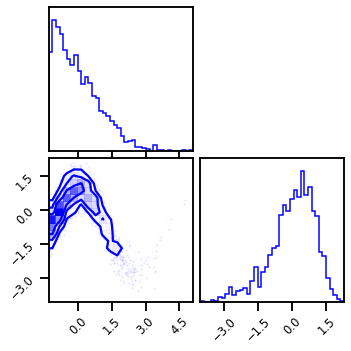

In [23]:

# cascade the transform
X_approx, _ = cascade_inverse_and_log_det(bijectors, X_l2)

# plot latent space
fig = corner.corner(X_approx, color="blue", hist_bin_factor=2)

### Convenience Function

In [24]:
from typing import List, Iterable
from rbig_jax.transforms.base import BijectorChain

In [25]:
# initialize chain
chain_bijectors = BijectorChain(bijectors=bijectors)

In [26]:
X_l3.min(), X_l3.max(), X_l3.shape

(DeviceArray(-4.6604214, dtype=float32),
 DeviceArray(3.9836667, dtype=float32),
 (2000, 2))

In [27]:
X_l3_ldj.min(), X_l3_ldj.max(), X_l3_ldj.shape

(DeviceArray(0., dtype=float32), DeviceArray(0., dtype=float32), (2000, 2))

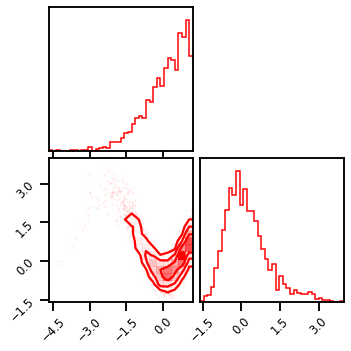

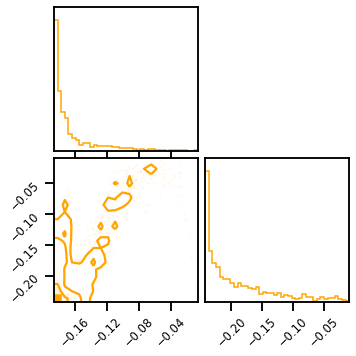

In [28]:
# cascade the transform
X_l3, X_l3_ldj = chain_bijectors.forward_and_log_det(X)

# plot latent space
fig = corner.corner(X_l3, color="red", hist_bin_factor=2)

# plot gradient
fig = corner.corner(X_l3_ldj, color="orange", hist_bin_factor=2)

## Training

In [46]:
from rbig_jax.data import DensityDataset, collate_fn
import torch.multiprocessing as multiprocessing
from torch.utils.data import DataLoader

# multiprocessing.set_start_method("spawn")

# initialize dataset
ds = DensityDataset(np.array(data))

# initialize dataloader
batch_size = 128
shuffle = True

dl = DataLoader(
    ds, batch_size=batch_size, shuffle=shuffle, collate_fn=None, num_workers=0
)

In [50]:
# spline parameters
n_components = 20
n_features = 2
shape = (2,)
key = jax.random.PRNGKey(123)

init_mixcdf_f = InitMixtureLogisticCDF(
    n_components=n_components,
)

mcdf_bijector = init_mixcdf_f(key, n_features)

# Logit transform
logit_bijector = Inverse(Sigmoid())

# Householder Transformation
n_reflections = 2
init_func = InitHouseHolder(n_reflections=n_reflections)


# initialize the bijector
key, hh_rng = jax.random.split(key, 2)

hh_bijector = init_func(hh_rng, n_features)

# create chain
bijectors = [mcdf_bijector, logit_bijector, hh_bijector]
chain_bijectors = BijectorChain(bijectors=bijectors)

### Loss Function

In [51]:
import jax.numpy as jnp
from rbig_jax.training import init_log_prob
from rbig_jax.loss import init_nll_loss
from distrax._src.distributions.normal import Normal

# init base distribtion (Gaussian)
base_dist = Normal(jnp.zeros((2,)), jnp.ones((2,)))

# create log probability
log_prob = init_log_prob(base_dist)

# create loss function
nll_loss = init_nll_loss(log_prob)

In [52]:
log_prob(chain_bijectors, X[:10]).shape

(10,)

### Optimizers

In [53]:
from jax.experimental import optimizers
from rbig_jax.training import init_train_op, train_model


lr = 0.05
optimizer = optimizers.adam
jitted = True
epochs = 150

# initialize training procedure
train_op, opt_params = init_train_op(
    chain_bijectors, nll_loss, optimizer, lr=lr, jitted=jitted
)

### Training Loop

In [54]:

# train model
final_bijector, losses = train_model(train_op, opt_params, dl, epochs=epochs,)

100%|██████████| 150/150 [00:10<00:00, 13.67it/s, loss=2.6052]


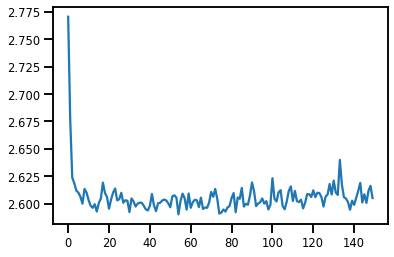

In [55]:
plt.plot(losses)

## Results

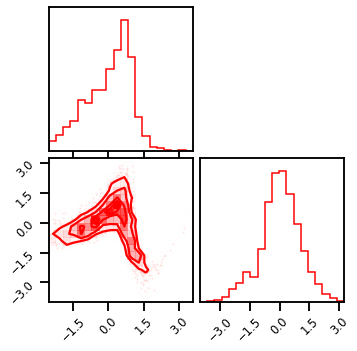

In [56]:
X_trans = final_bijector.forward(data)
# X_trans, _ = final_bijector.forward_and_log_det(data)

fig = corner.corner(X_trans, color="Red")

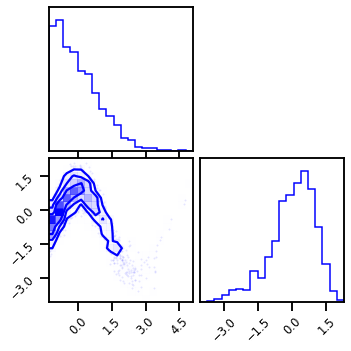

In [57]:
X_approx = final_bijector.inverse(X_trans)

fig = corner.corner(X_approx, color="Blue")

## More Layers

In [59]:
# spline parameters
range_min = -10.0
n_components = 20
n_features = 2
shape = (2,)
key = jax.random.PRNGKey(123)

init_mixcdf_f = InitMixtureLogisticCDF(
    n_components=n_components,
)

# Logit Transformation
logit_bijector = Inverse(Sigmoid())

# Householder Transformation
n_reflections = 1
init_hh_func = InitHouseHolder(n_reflections=n_reflections)

# create keys for all inits
n_layers = 5
bijectors = []

rng, *layer_rngs = jax.random.split(KEY, num=n_layers)

for irng in layer_rngs:
    
    # create keys for all inits
    bijectors.append(init_mixcdf_f(irng, n_features))
    
    # create keys for all inits
#     bijectors.append(init_logit_func(irng, n_features))
    bijectors.append(logit_bijector)
    
    # create keys for all inits
    bijectors.append(init_hh_func(hh_rng, n_features))

# create chain
chain_bijectors = BijectorChain(bijectors=bijectors)

### Retrain

In [60]:
# initialize training procedure
lr = 0.005
optimizer = optimizers.adam
jitted = True
epochs = 500

train_op, opt_params = init_train_op(
    chain_bijectors, nll_loss, optimizer, lr=lr, jitted=jitted
)


# train model
final_bijector, losses = train_model(train_op, opt_params, dl, epochs=epochs,)

100%|██████████| 500/500 [00:45<00:00, 10.87it/s, loss=1.8769]


### Results

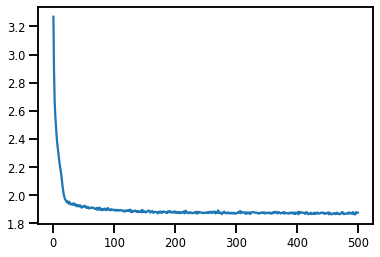

In [61]:
plt.plot(losses)

#### Latent Space

CPU times: user 654 ms, sys: 12.9 ms, total: 667 ms
Wall time: 611 ms


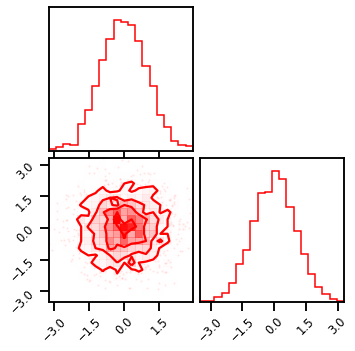

In [62]:
%%time
X_trans = final_bijector.forward(data)

fig = corner.corner(X_trans, color="Red")

#### Inverse Transform

CPU times: user 19.6 s, sys: 1.89 s, total: 21.4 s
Wall time: 9.96 s


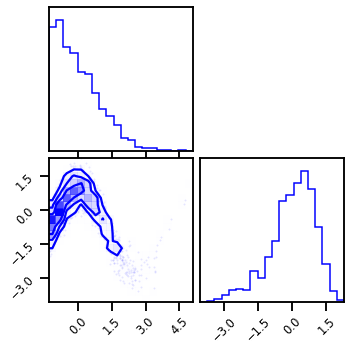

In [63]:
%%time

X_approx = final_bijector.inverse(X_trans)

fig = corner.corner(X_approx, color="Blue")

In [64]:
inv_f = jax.jit(final_bijector.inverse)

CPU times: user 12.8 s, sys: 1.77 s, total: 14.6 s
Wall time: 1.9 s


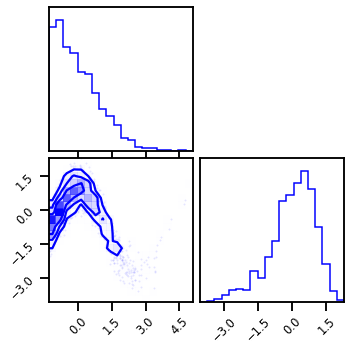

In [66]:
%%time

X_approx = inv_f(X_trans)

fig = corner.corner(X_approx, color="Blue")

### Log Probability

In [86]:
from rbig_jax.data import generate_2d_grid

In [90]:
xyinput = generate_2d_grid(X, 200, buffer=0.1)

In [91]:
X_log_prob = log_prob(final_bijector, xyinput)

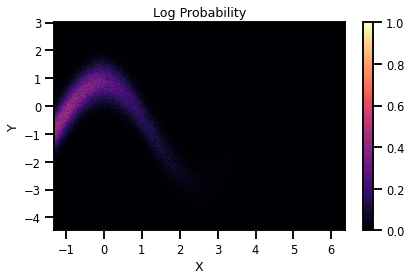

In [112]:
n_samples = 1_000_000
n_features = 2
X_plot = get_classic(n_samples, seed=123)
X_plot = StandardScaler().fit_transform(X_plot)


fig, ax = plt.subplots()
h = ax.hist2d(X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0., vmax=1.)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h[3])
ax.set_title(title)
plt.tight_layout()
plt.show()

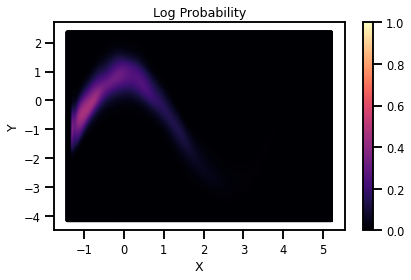

In [100]:
from matplotlib import cm

cmap = cm.magma # "Reds"
probs = jnp.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)
title = "Density"

fig, ax = plt.subplots()
h = ax.scatter(xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()
plt.show()

### Sampling

In [113]:
%%time
# generate samples in the latent domain
n_gen_samples = 100_000

X_g_samples = base_dist.sample(seed=123, sample_shape=(n_gen_samples))

# # inverse transformation
X_samples = inv_f(X_g_samples)

CPU times: user 3.56 s, sys: 4.71 ms, total: 3.57 s
Wall time: 3.53 s


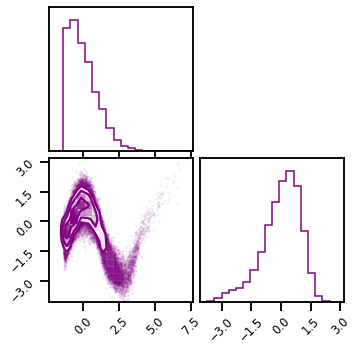

In [114]:
fig = corner.corner(X_samples, color="purple")